<h1 style='color:purple' align='center'>Data Science Regression Project: Predicting Home Prices in Canada</h1>

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

<h2 style='color:blue'>Data Load: Load Canada home prices into a dataframe</h2>

In [3]:
df1 = pd.read_csv('house_listings_data.csv',encoding='latin-1')


In [4]:
df1.head()

,City,Price,Address,Number_Beds,Number_Baths,Province,Population,Latitude,Longitude,Median_Family_Income
0,Toronto,779900.0,#318 -20 SOUTHPORT ST,3,2,Ontario,5647656,43.7417,-79.3733,97000.0
1,Toronto,799999.0,#818 -60 SOUTHPORT ST,3,1,Ontario,5647656,43.7417,-79.3733,97000.0
2,Toronto,799900.0,#714 -859 THE QUEENSWAY,2,2,Ontario,5647656,43.7417,-79.3733,97000.0
3,Toronto,1200000.0,275 MORTIMER AVE,4,2,Ontario,5647656,43.7417,-79.3733,97000.0
4,Toronto,668800.0,#420 -388 RICHMOND ST,1,1,Ontario,5647656,43.7417,-79.3733,97000.0


In [5]:
df1.shape

(35768, 10)

In [6]:
df1.columns

Index(['City', 'Price', 'Address', 'Number_Beds', 'Number_Baths', 'Province',
       'Population', 'Latitude', 'Longitude', 'Median_Family_Income'],
      dtype='object')

In [7]:
df1['Province'].unique()

array(['Ontario', 'British Columbia', 'Alberta', 'Manitoba',
       'Saskatchewan', 'Newfoundland and Labrador', 'New Brunswick',
       'Quebec', 'Nova Scotia'], dtype=object)

In [8]:
df1['Number_Beds'].value_counts()

Number_Beds
3      10174
4       7831
2       7724
5       4004
1       2729
6       1581
0        769
7        511
8        253
9         96
10        35
11        17
12        13
15         6
16         5
20         3
17         2
18         2
30         1
36         1
14         1
46         1
40         1
109        1
35         1
21         1
47         1
27         1
26         1
13         1
19         1
Name: count, dtype: int64

In [9]:
df1['Number_Baths'].unique()

array([ 2,  1,  3,  4,  5,  0,  6,  7,  8,  9, 11, 10, 12, 16, 25, 17, 59,
       15, 21, 14, 20, 22])

**Drop features that are not required to build our model**

In [10]:
df2 = df1.drop(['Province'],axis='columns')
df2.shape

(35768, 9)

<h2 style='color:blue'>Data Cleaning: Handle NA values</h2>

In [11]:
df2.isnull().sum()

City                    0
Price                   0
Address                 0
Number_Beds             0
Number_Baths            0
Population              0
Latitude                0
Longitude               0
Median_Family_Income    0
dtype: int64

In [12]:
df2.shape

(35768, 9)

In [13]:
df3 = df2.dropna()
df3.isnull().sum()

City                    0
Price                   0
Address                 0
Number_Beds             0
Number_Baths            0
Population              0
Latitude                0
Longitude               0
Median_Family_Income    0
dtype: int64

In [14]:
df3.shape

(35768, 9)

<h2 style='color:blue'>Feature Engineering</h2>

**There are rooms graeter 16 in one house**

In [15]:
df3_filter= df3[df3['Number_Beds']>=6]
df3_filter

,City,Price,Address,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income
41,Toronto,1299000.0,35 TROUTBROOKE DR,6,3,5647656,43.7417,-79.3733,97000.0
74,Toronto,899000.0,27 VERNON RD,6,4,5647656,43.7417,-79.3733,97000.0
86,Toronto,2150000.0,5 HIGHBOURNE RD,6,2,5647656,43.7417,-79.3733,97000.0
92,Toronto,1150000.0,1678 EGLINTON AVE W,7,5,5647656,43.7417,-79.3733,97000.0
94,Toronto,3679000.0,126 LEE AVE,6,4,5647656,43.7417,-79.3733,97000.0
...,...,...,...,...,...,...,...,...,...
35661,Trois-Rivieres,575000.0,1365 rue Houle,6,2,139163,46.3500,-72.5500,62400.0
35670,Trois-Rivieres,575000.0,1365 rue Houle,6,2,139163,46.3500,-72.5500,62400.0
35712,Halifax,1047000.0,4 Samuel Terrace,7,5,431479,44.8857,63.1005,86753.0
35713,Halifax,639000.0,64 Convoy Avenue,6,2,431479,44.8857,63.1005,86753.0


In [16]:
df4=df3[df3['Number_Beds']<=6]

In [17]:
average_beds=df4['Number_Beds'].mean()
average_baths=df4['Number_Baths'].mean()

In [18]:
average_rnd_beds = round(average_beds)
average_rnd_baths = round(average_baths)

In [19]:
print("Average number of beds:", average_rnd_beds)
print("Average number of baths:", average_rnd_baths)

Average number of beds: 3
Average number of baths: 2


** Replace outliers Number of beds & Baths by Average of df3 dataset**

In [20]:
df3_filter['Number_Beds']=3

C:\Users\agasaja\AppData\Local\Temp\ipykernel_119268\3905198290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_filter['Number_Beds']=3


In [21]:
df3_filter['Number_Baths']=3

C:\Users\agasaja\AppData\Local\Temp\ipykernel_119268\1082703201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_filter['Number_Baths']=3


In [22]:
df3_filter

,City,Price,Address,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income
41,Toronto,1299000.0,35 TROUTBROOKE DR,3,3,5647656,43.7417,-79.3733,97000.0
74,Toronto,899000.0,27 VERNON RD,3,3,5647656,43.7417,-79.3733,97000.0
86,Toronto,2150000.0,5 HIGHBOURNE RD,3,3,5647656,43.7417,-79.3733,97000.0
92,Toronto,1150000.0,1678 EGLINTON AVE W,3,3,5647656,43.7417,-79.3733,97000.0
94,Toronto,3679000.0,126 LEE AVE,3,3,5647656,43.7417,-79.3733,97000.0
...,...,...,...,...,...,...,...,...,...
35661,Trois-Rivieres,575000.0,1365 rue Houle,3,3,139163,46.3500,-72.5500,62400.0
35670,Trois-Rivieres,575000.0,1365 rue Houle,3,3,139163,46.3500,-72.5500,62400.0
35712,Halifax,1047000.0,4 Samuel Terrace,3,3,431479,44.8857,63.1005,86753.0
35713,Halifax,639000.0,64 Convoy Avenue,3,3,431479,44.8857,63.1005,86753.0


In [23]:
df4= pd.concat([df4,df3_filter],ignore_index= True)

In [24]:
df4.head()

,City,Price,Address,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income
0,Toronto,779900.0,#318 -20 SOUTHPORT ST,3,2,5647656,43.7417,-79.3733,97000.0
1,Toronto,799999.0,#818 -60 SOUTHPORT ST,3,1,5647656,43.7417,-79.3733,97000.0
2,Toronto,799900.0,#714 -859 THE QUEENSWAY,2,2,5647656,43.7417,-79.3733,97000.0
3,Toronto,1200000.0,275 MORTIMER AVE,4,2,5647656,43.7417,-79.3733,97000.0
4,Toronto,668800.0,#420 -388 RICHMOND ST,1,1,5647656,43.7417,-79.3733,97000.0


In [25]:
# Replace bath outliers (>=6) with mean (rounded to 3)
df4.loc[df4['Number_Baths'] >= 6, 'Number_Baths'] = average_rnd_baths
print("Replaced Number_Baths >= 6 with:", average_rnd_baths)

# Quick check
print("Number_Baths counts after replacement:")
df4['Number_Baths'].value_counts()

# Show any remaining rows with Number_Baths >= 6 (should be none)
df4[df4['Number_Baths'] >= 6]

Replaced Number_Baths >= 6 with: 2
Number_Baths counts after replacement:


,City,Price,Address,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income


In [26]:
df5=df4.copy()

In [27]:
df5

,City,Price,Address,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income
0,Toronto,779900.0,#318 -20 SOUTHPORT ST,3,2,5647656,43.7417,-79.3733,97000.0
1,Toronto,799999.0,#818 -60 SOUTHPORT ST,3,1,5647656,43.7417,-79.3733,97000.0
2,Toronto,799900.0,#714 -859 THE QUEENSWAY,2,2,5647656,43.7417,-79.3733,97000.0
3,Toronto,1200000.0,275 MORTIMER AVE,4,2,5647656,43.7417,-79.3733,97000.0
4,Toronto,668800.0,#420 -388 RICHMOND ST,1,1,5647656,43.7417,-79.3733,97000.0
...,...,...,...,...,...,...,...,...,...
37344,Trois-Rivieres,575000.0,1365 rue Houle,3,3,139163,46.3500,-72.5500,62400.0
37345,Trois-Rivieres,575000.0,1365 rue Houle,3,3,139163,46.3500,-72.5500,62400.0
37346,Halifax,1047000.0,4 Samuel Terrace,3,3,431479,44.8857,63.1005,86753.0
37347,Halifax,639000.0,64 Convoy Avenue,3,3,431479,44.8857,63.1005,86753.0


In [28]:
df5.to_csv("bhp.csv",index=False)

**Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations**

In [29]:
df5.City = df5.City.apply(lambda x: x.strip())
location_stats = df5['City'].value_counts(ascending=False)
location_stats

City
Regina              1965
Saskatoon           1867
Caledon             1473
New Westminster     1401
London              1396
Vancouver           1395
Victoria            1387
Edmonton            1385
Burnaby             1384
Calgary             1365
Maple Ridge         1361
Hamilton            1352
Kelowna             1344
St. Catharines      1310
Toronto             1303
White Rock          1264
Kitchener           1250
Oshawa              1131
Ottawa              1124
Barrie              1067
Abbotsford           842
Windsor              764
Nanaimo              704
St. John's           667
Brantford            652
Winnipeg             536
Kingston             504
Saint John           468
Kamloops             465
Guelph               452
Moncton              432
Lethbridge           394
Red Deer             344
Prince George        335
Peterborough         317
Medicine Hat         283
Airdrie              235
Montreal             216
Sudbury              209
Quebec              

In [30]:
location_stats.values.sum()

np.int64(37349)

In [31]:
len(location_stats[location_stats<200])

4

In [32]:
len(location_stats)

45

In [33]:
len(location_stats[location_stats<=1000])

25

<h2 style="color:blue">Dimensionality Reduction</h2>

**Any location having less than 1000 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns**

In [34]:
location_stats_less_than_1000 = location_stats[location_stats<=1000]
location_stats_less_than_1000

City
Abbotsford          842
Windsor             764
Nanaimo             704
St. John's          667
Brantford           652
Winnipeg            536
Kingston            504
Saint John          468
Kamloops            465
Guelph              452
Moncton             432
Lethbridge          394
Red Deer            344
Prince George       335
Peterborough        317
Medicine Hat        283
Airdrie             235
Montreal            216
Sudbury             209
Quebec              205
Sherbrooke          201
Trois-Rivieres      179
Sault Ste. Marie    169
Thunder Bay         160
Halifax              92
Name: count, dtype: int64

In [35]:
len(df5.City.unique())

45

In [36]:
df5.City = df5.City.apply(lambda x: 'other' if x in location_stats_less_than_1000 else x)
len(df5.City.unique())

21

In [37]:
df5.head(10)

,City,Price,Address,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income
0,Toronto,779900.0,#318 -20 SOUTHPORT ST,3,2,5647656,43.7417,-79.3733,97000.0
1,Toronto,799999.0,#818 -60 SOUTHPORT ST,3,1,5647656,43.7417,-79.3733,97000.0
2,Toronto,799900.0,#714 -859 THE QUEENSWAY,2,2,5647656,43.7417,-79.3733,97000.0
3,Toronto,1200000.0,275 MORTIMER AVE,4,2,5647656,43.7417,-79.3733,97000.0
4,Toronto,668800.0,#420 -388 RICHMOND ST,1,1,5647656,43.7417,-79.3733,97000.0
5,Toronto,548000.0,#2503 -99 HARBOUR SQ,0,1,5647656,43.7417,-79.3733,97000.0
6,Toronto,669900.0,#817 -151 DAN LECKIE WAY,2,1,5647656,43.7417,-79.3733,97000.0
7,Toronto,699000.0,#1107 -438 KING ST W,2,2,5647656,43.7417,-79.3733,97000.0
8,Toronto,978000.0,#2708 -20 EDWARD ST,3,2,5647656,43.7417,-79.3733,97000.0
9,Toronto,958000.0,#4616 -386 YONGE ST,2,2,5647656,43.7417,-79.3733,97000.0


In [38]:
df6=df5.copy()

<h2 style='color:blue'>Outlier Removal Using Mean</h2>

In [39]:
df6.Price.describe()

count    3.734900e+04
mean     9.719627e+05
std      1.053990e+06
min      2.150000e+04
25%      4.699000e+05
50%      6.999990e+05
75%      1.129000e+06
max      3.700000e+07
Name: Price, dtype: float64

In [40]:
df6[df6['Price']>20000000.0]

,City,Price,Address,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income
1782,Vancouver,23800000.0,1123 CRESTLINE ROAD,6,2,2426160,49.2500,-123.1000,90000.0
25001,White Rock,28800000.0,17499 20 AVENUE,4,3,109167,49.0250,-122.8028,73000.0
25879,White Rock,27999999.0,2165 123 STREET,5,2,109167,49.0250,-122.8028,73000.0
34899,Vancouver,23800000.0,1123 CRESTLINE ROAD,3,3,2426160,49.2500,-123.1000,90000.0
35859,Barrie,37000000.0,1775 RIDGE RD W,3,3,154676,44.3711,-79.6769,97000.0


In [41]:
df6_filter = df6[df6['Price']>=20000000.0]
df6_filter


,City,Price,Address,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income
1782,Vancouver,23800000.0,1123 CRESTLINE ROAD,6,2,2426160,49.2500,-123.1000,90000.0
25001,White Rock,28800000.0,17499 20 AVENUE,4,3,109167,49.0250,-122.8028,73000.0
25879,White Rock,27999999.0,2165 123 STREET,5,2,109167,49.0250,-122.8028,73000.0
34899,Vancouver,23800000.0,1123 CRESTLINE ROAD,3,3,2426160,49.2500,-123.1000,90000.0
35859,Barrie,37000000.0,1775 RIDGE RD W,3,3,154676,44.3711,-79.6769,97000.0


Replacing All Home Prices with 20M to Mean of data

In [42]:
mean_price = df6[df6['Price']<=20000000.0]['Price'].mean()
mean_price

np.float64(968306.4532401457)

In [43]:
df6_filter['Price']=mean_price
df6_filter

C:\Users\agasaja\AppData\Local\Temp\ipykernel_119268\2379143267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6_filter['Price']=mean_price


,City,Price,Address,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income
1782,Vancouver,968306.45324,1123 CRESTLINE ROAD,6,2,2426160,49.2500,-123.1000,90000.0
25001,White Rock,968306.45324,17499 20 AVENUE,4,3,109167,49.0250,-122.8028,73000.0
25879,White Rock,968306.45324,2165 123 STREET,5,2,109167,49.0250,-122.8028,73000.0
34899,Vancouver,968306.45324,1123 CRESTLINE ROAD,3,3,2426160,49.2500,-123.1000,90000.0
35859,Barrie,968306.45324,1775 RIDGE RD W,3,3,154676,44.3711,-79.6769,97000.0


In [44]:
df7= pd.concat([df6[df6['Price']<=20000000.0],df6_filter],ignore_index=True)
df7.describe()

,Price,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income
count,3.734900e+04,37349.000000,37349.000000,3.734900e+04,37349.000000,37349.000000,37349.000000
mean,9.683065e+05,3.136362,2.429945,6.293737e+05,47.441974,-98.526132,89733.496908
std,1.003955e+06,1.298190,1.060249,1.111099e+06,3.331557,22.242824,12293.986797
min,2.150000e+04,0.000000,0.000000,6.338200e+04,42.283300,-123.936400,62400.000000
25%,4.699000e+05,2.000000,2.000000,1.091670e+05,43.866700,-122.316700,82000.000000
50%,6.999990e+05,3.000000,2.000000,2.424600e+05,49.025000,-104.606700,89000.000000
75%,1.129000e+06,4.000000,3.000000,5.228880e+05,49.888100,-79.866700,97000.000000
max,1.988000e+07,6.000000,5.000000,5.647656e+06,53.916900,63.100500,133000.000000


**Here we find that min price 21500 whereas max we still is 19880000.0, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [45]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('City'):
        m = np.mean(subdf.Price)
        st = np.std(subdf.Price)
        reduced_df = subdf[(subdf.Price>(m-st)) & (subdf.Price<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df8 = remove_pps_outliers(df7)
df8.shape

(33334, 9)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

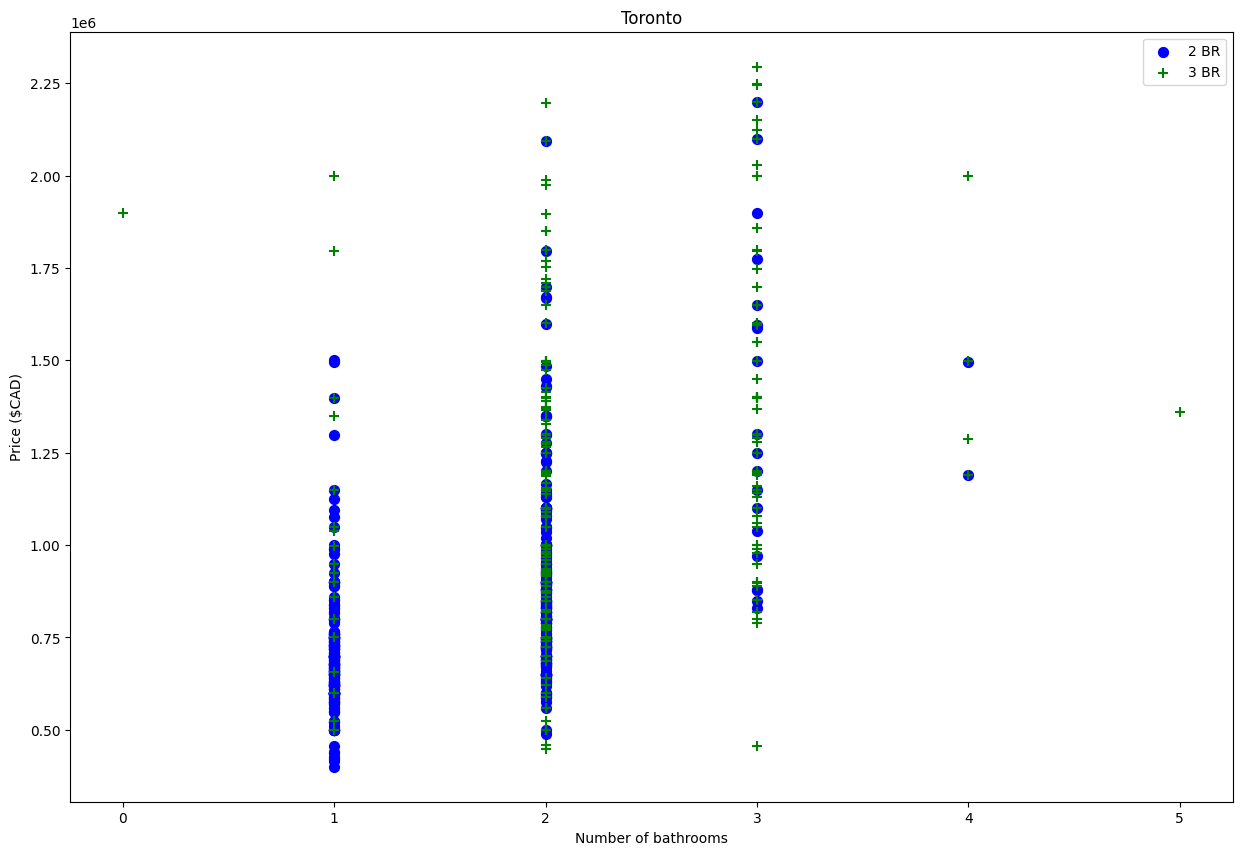

In [46]:
def plot_scatter_chart(df, city):
    br2 = df[(df.City == city) & (df.Number_Beds == 2)]
    br3 = df[(df.City == city) & (df.Number_Beds == 3)]
    matplotlib.rcParams['figure.figsize'] = (15, 10)
    plt.scatter(br2.Number_Baths, br2.Price, color='blue', label='2 BR', s=50)
    plt.scatter(br3.Number_Baths, br3.Price, marker='+', color='green', label='3 BR', s=50)
    plt.xlabel("Number of bathrooms")
    plt.ylabel("Price ($CAD)")
    plt.title(city)
    plt.legend()

plot_scatter_chart(df8, "Toronto")

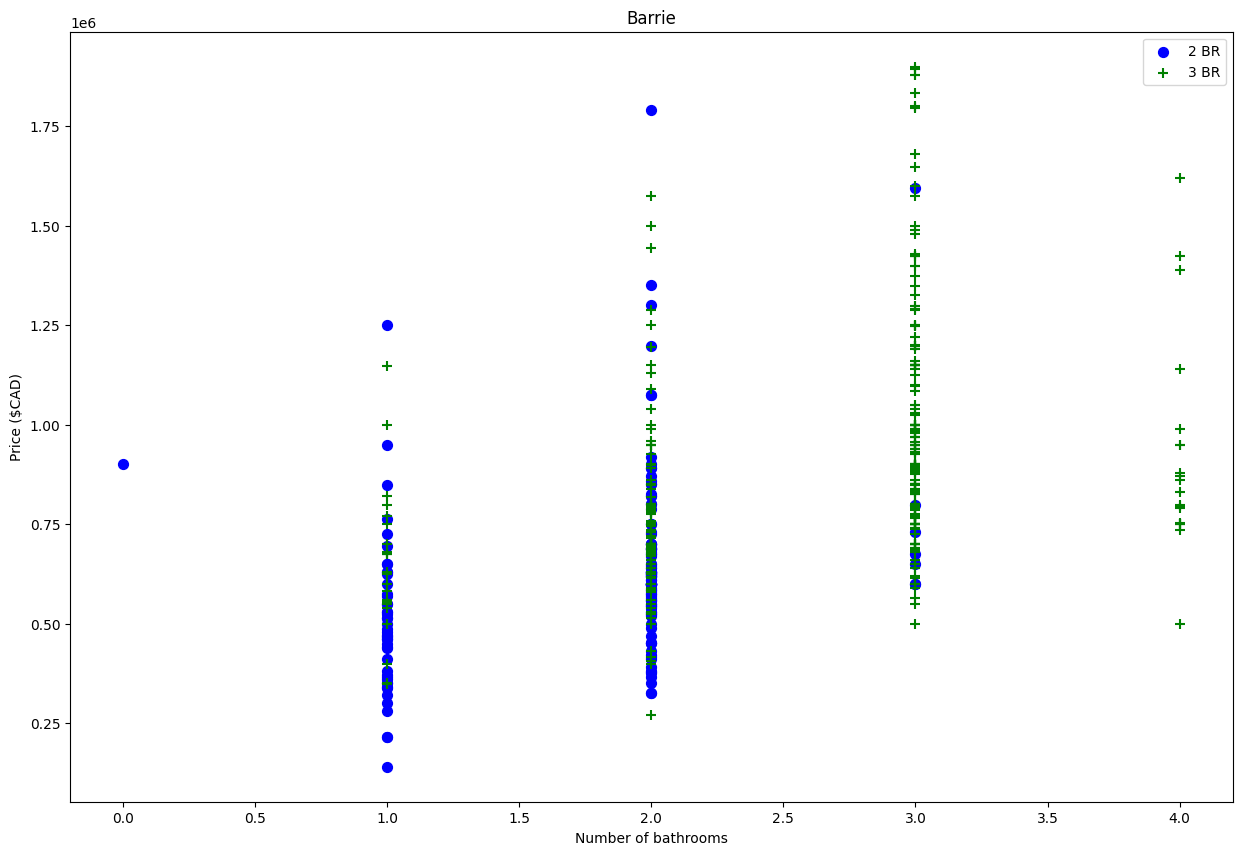

In [47]:
plot_scatter_chart(df8,"Barrie")

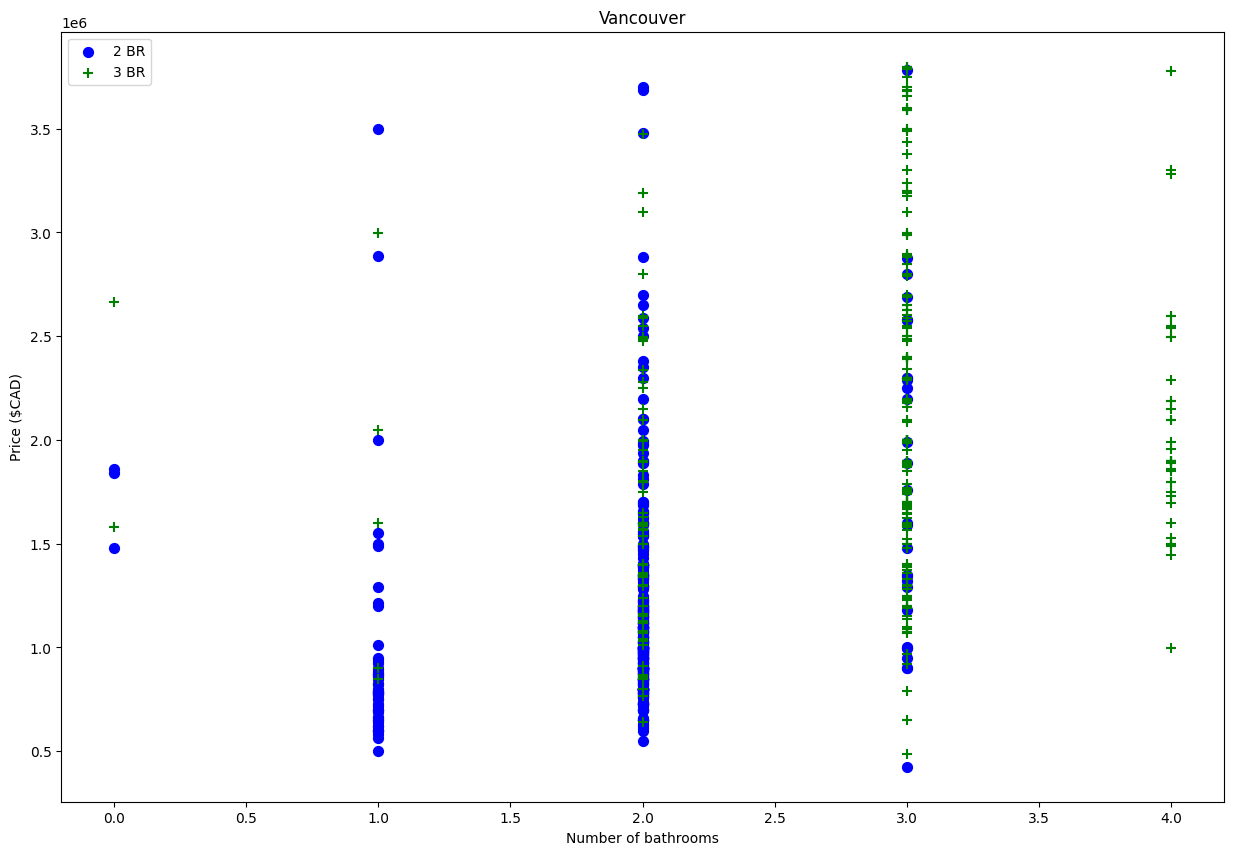

In [48]:
plot_scatter_chart(df8, "Vancouver")

Text(0, 0.5, 'Count')

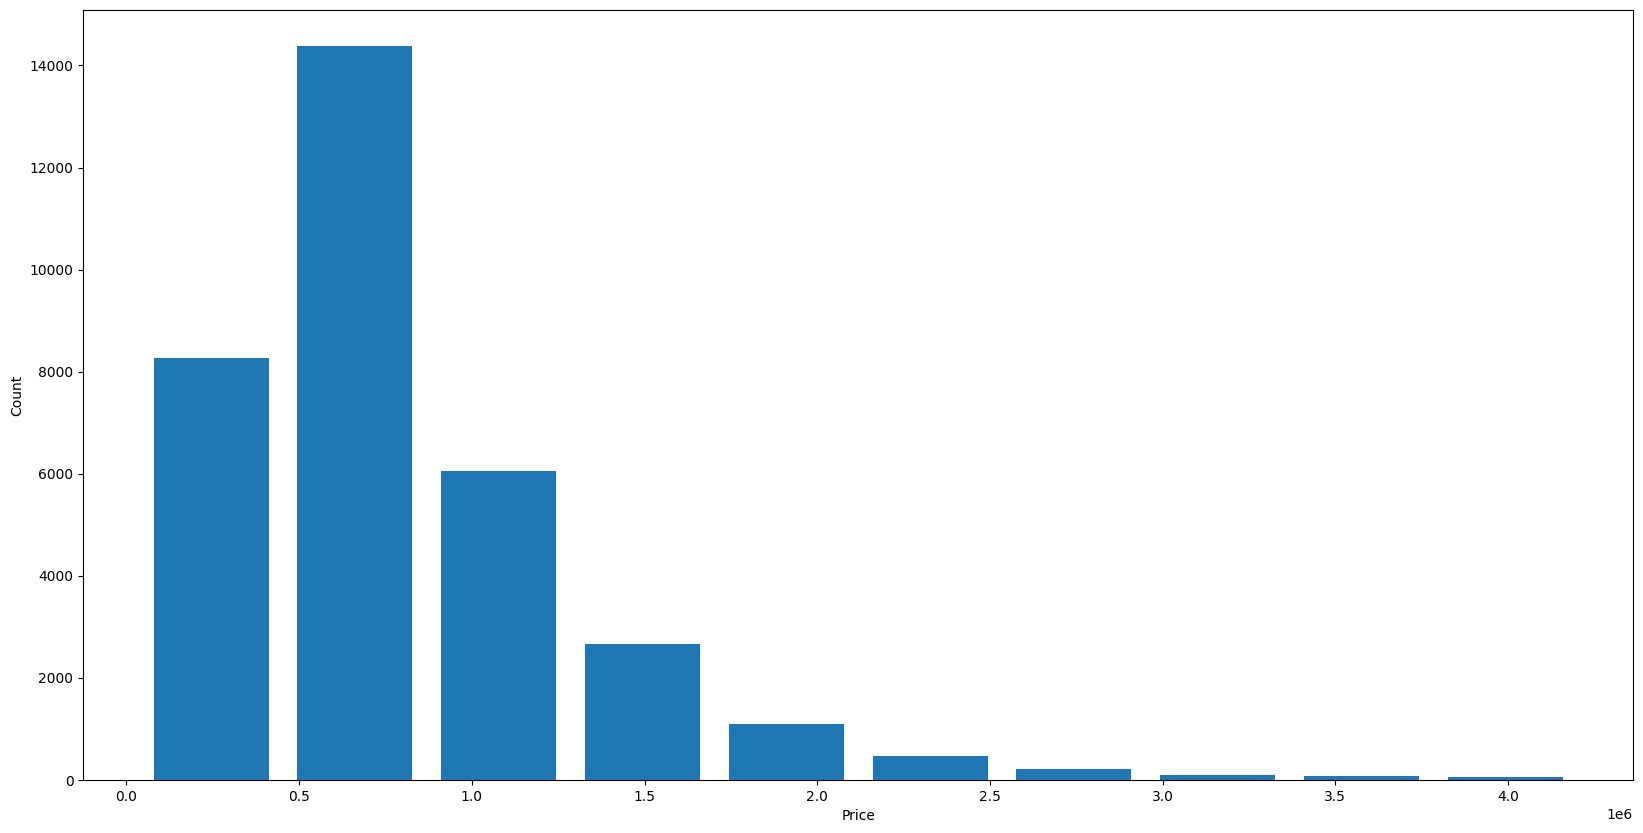

In [49]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.Price,rwidth=0.8)
plt.xlabel("Price")
plt.ylabel("Count")

<h2 style='color:blue'>Outlier Removal Using Bathrooms Feature</h2>

In [50]:
df8.Number_Baths.unique()

array([4, 2, 3, 1, 5, 0])

Text(0, 0.5, 'Count')

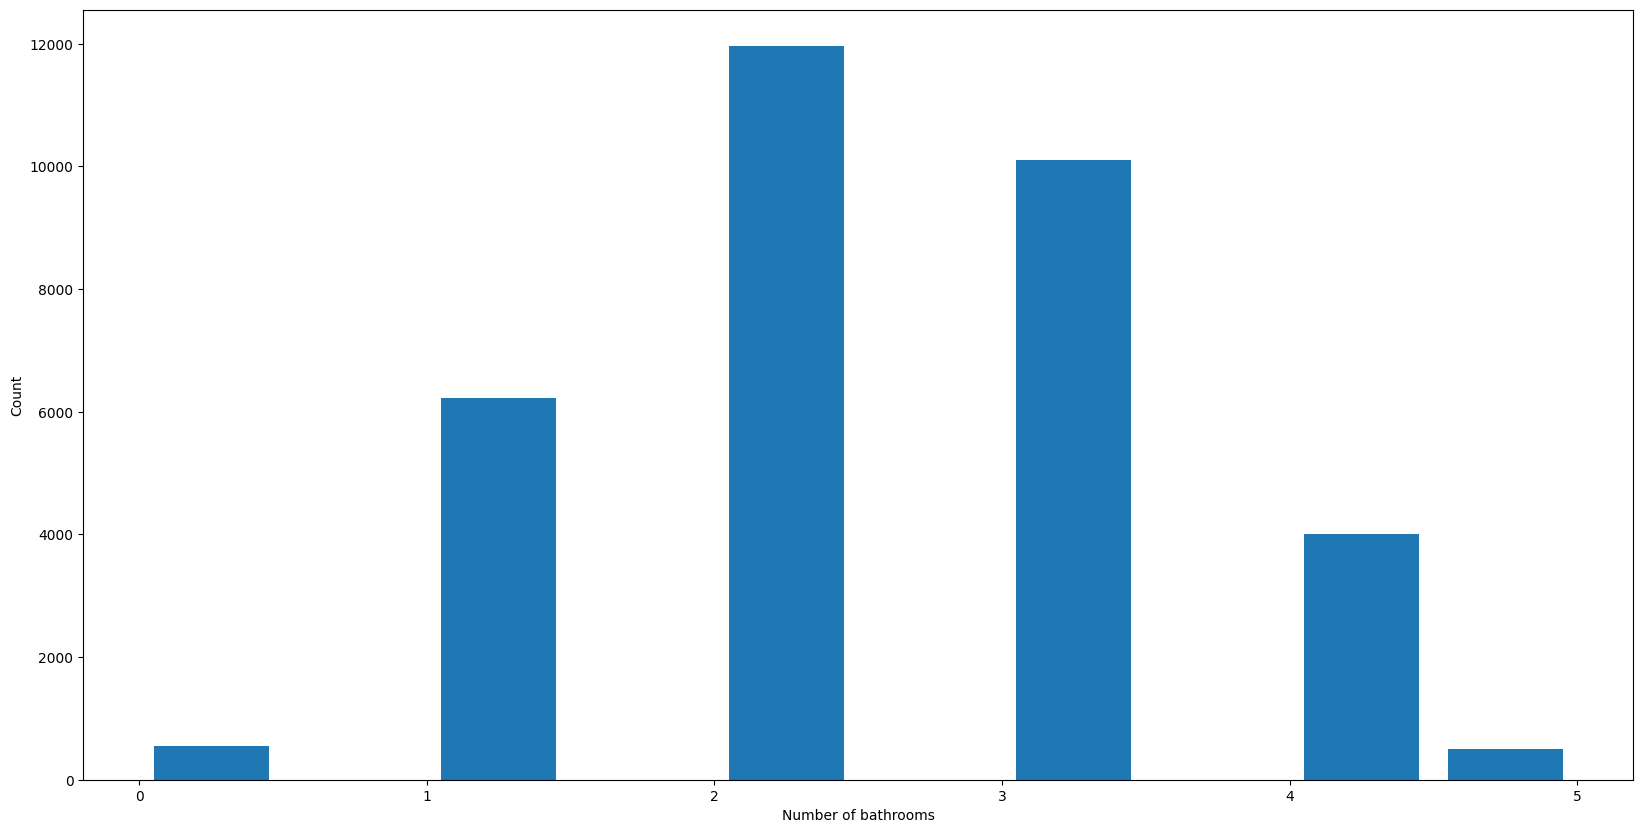

In [51]:
plt.hist(df8.Number_Baths,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [52]:
df8[df8.Number_Baths>10]

,City,Price,Address,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income


In [53]:
df9=df8.copy()
df9

,City,Price,Address,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income
0,Barrie,799000.0,70 RED OAK Drive,3,4,154676,44.3711,-79.6769,97000.0
1,Barrie,1049000.0,104 DURHAM AVE W,4,4,154676,44.3711,-79.6769,97000.0
2,Barrie,589900.0,#301 -100 DEAN AVE,3,2,154676,44.3711,-79.6769,97000.0
3,Barrie,869900.0,#1,5,3,154676,44.3711,-79.6769,97000.0
4,Barrie,689900.0,105 LAIDLAW Drive,3,2,154676,44.3711,-79.6769,97000.0
...,...,...,...,...,...,...,...,...,...
33329,other,575000.0,1365 rue Houle,3,3,139163,46.3500,-72.5500,62400.0
33330,other,575000.0,1365 rue Houle,3,3,139163,46.3500,-72.5500,62400.0
33331,other,1047000.0,4 Samuel Terrace,3,3,431479,44.8857,63.1005,86753.0
33332,other,639000.0,64 Convoy Avenue,3,3,431479,44.8857,63.1005,86753.0


<h2 style='color:blue'>Use One Hot Encoding For Location</h2>

In [54]:
dummies = pd.get_dummies(df9.City)
dummies.head(3)

,Barrie,Burnaby,Caledon,Calgary,Edmonton,Hamilton,Kelowna,Kitchener,London,Maple Ridge,...,Oshawa,Ottawa,Regina,Saskatoon,St. Catharines,Toronto,Vancouver,Victoria,White Rock,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [55]:
df10 = pd.concat([df9,dummies.drop('other',axis='columns')],axis='columns')
df10.head()

,City,Price,Address,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income,Barrie,...,New Westminster,Oshawa,Ottawa,Regina,Saskatoon,St. Catharines,Toronto,Vancouver,Victoria,White Rock
0,Barrie,799000.0,70 RED OAK Drive,3,4,154676,44.3711,-79.6769,97000.0,True,...,False,False,False,False,False,False,False,False,False,False
1,Barrie,1049000.0,104 DURHAM AVE W,4,4,154676,44.3711,-79.6769,97000.0,True,...,False,False,False,False,False,False,False,False,False,False
2,Barrie,589900.0,#301 -100 DEAN AVE,3,2,154676,44.3711,-79.6769,97000.0,True,...,False,False,False,False,False,False,False,False,False,False
3,Barrie,869900.0,#1,5,3,154676,44.3711,-79.6769,97000.0,True,...,False,False,False,False,False,False,False,False,False,False
4,Barrie,689900.0,105 LAIDLAW Drive,3,2,154676,44.3711,-79.6769,97000.0,True,...,False,False,False,False,False,False,False,False,False,False


In [56]:
df11 = df10.drop('City',axis='columns')
df11.head(2)

,Price,Address,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income,Barrie,Burnaby,...,New Westminster,Oshawa,Ottawa,Regina,Saskatoon,St. Catharines,Toronto,Vancouver,Victoria,White Rock
0,799000.0,70 RED OAK Drive,3,4,154676,44.3711,-79.6769,97000.0,True,False,...,False,False,False,False,False,False,False,False,False,False
1,1049000.0,104 DURHAM AVE W,4,4,154676,44.3711,-79.6769,97000.0,True,False,...,False,False,False,False,False,False,False,False,False,False


In [57]:
df12 = df11.drop('Address',axis='columns')
df12.head(2)

,Price,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income,Barrie,Burnaby,Caledon,...,New Westminster,Oshawa,Ottawa,Regina,Saskatoon,St. Catharines,Toronto,Vancouver,Victoria,White Rock
0,799000.0,3,4,154676,44.3711,-79.6769,97000.0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1049000.0,4,4,154676,44.3711,-79.6769,97000.0,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [58]:
df12 = df12.drop(['Latitude','Longitude','Population','Median_Family_Income'],axis='columns')
df12.head(2)

,Price,Number_Beds,Number_Baths,Barrie,Burnaby,Caledon,Calgary,Edmonton,Hamilton,Kelowna,...,New Westminster,Oshawa,Ottawa,Regina,Saskatoon,St. Catharines,Toronto,Vancouver,Victoria,White Rock
0,799000.0,3,4,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1049000.0,4,4,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<h2 style='color:blue'>Build a Model Now...</h2>

In [59]:
df12.shape

(33334, 23)

In [60]:
X = df12.drop(['Price'],axis='columns')
X.head(3)

,Number_Beds,Number_Baths,Barrie,Burnaby,Caledon,Calgary,Edmonton,Hamilton,Kelowna,Kitchener,...,New Westminster,Oshawa,Ottawa,Regina,Saskatoon,St. Catharines,Toronto,Vancouver,Victoria,White Rock
0,3,4,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4,4,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,2,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [61]:
X

,Number_Beds,Number_Baths,Barrie,Burnaby,Caledon,Calgary,Edmonton,Hamilton,Kelowna,Kitchener,...,New Westminster,Oshawa,Ottawa,Regina,Saskatoon,St. Catharines,Toronto,Vancouver,Victoria,White Rock
0,3,4,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4,4,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,2,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,5,3,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,3,2,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33329,3,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
33330,3,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
33331,3,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
33332,3,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [62]:
X.shape

(33334, 22)

In [63]:
y = df12.Price
y.head(3)

0     799000.0
1    1049000.0
2     589900.0
Name: Price, dtype: float64

In [64]:
len(y)

33334

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [66]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.5692190060886586

<h2 style='color:blue'>Use K Fold cross validation to measure accuracy of our LinearRegression model</h2>

In [67]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.57609153, 0.56757797, 0.5667483 , 0.55860489, 0.55999478])

**We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose**

<h2 style='color:blue'>Find best model using GridSearchCV</h2>

In [68]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'copy_X': [True, False],
                'fit_intercept': [True, False],
                'n_jobs': [None, -1],
                'positive': [True, False],
                'tol': [1e-4, 1e-3]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

c:\Users\agasaja\Python_Projects\forecast-home-prices-in-canada\.venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\agasaja\Python_Projects\forecast-home-prices-in-canada\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\agasaja\Python_Projects\forecast-home-prices-in-canada\.venv\lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "c:\Users\agasaja\Python_Projects\forecast-h

,model,best_score,best_params
0,linear_regression,0.565803,"{'copy_X': True, 'fit_intercept': True, 'n_job..."
1,lasso,0.565805,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.653438,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


**Based on above results we can say that LinearRegression gives the best score. Hence we will use that.**

<h2 style='color:blue'>Test the model for few properties</h2>

In [69]:
def predict_price(City,Number_Bed,Number_Baths):    
    loc_index = np.where(X.columns==City)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = Number_Bed
    x[1] = Number_Baths
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [70]:
predict_price('Toronto',2, 2)

c:\Users\agasaja\Python_Projects\forecast-home-prices-in-canada\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(950262.5715192804)

In [71]:
predict_price('Barrie',2, 2)

c:\Users\agasaja\Python_Projects\forecast-home-prices-in-canada\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(675519.6899405752)

In [72]:
predict_price('Vancouver',2, 2)

c:\Users\agasaja\Python_Projects\forecast-home-prices-in-canada\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(1389923.0742843747)

<h2 style='color:blue'>Export the tested model to a pickle file</h2>

In [73]:
import pickle
with open('canada_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

<h2 style='color:blue'>Export location and column information to a file that will be useful later on in our prediction application</h2>

In [74]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

<h2 style='color:blue'>Add log-transformed Population and Median Family Income</h2>
We will automatically detect the population and median income columns (case-insensitive),
convert them to numeric, clip non-positive values to 0, and compute `log1p` features.
These features are then added to the model for improved accuracy, as price often
scales non-linearly with population and income.

In [75]:
# Detect and create log features for population and median income
import numpy as np
import pandas as pd

# Use the cleaned dataset previously prepared
df_log = df9.copy()  # df9 exists earlier after cleaning steps

def find_col(cols, patterns_any, patterns_all=None):
    patterns_all = patterns_all or []
    for c in cols:
        s = c.lower().replace('_', ' ').strip()
        if any(p in s for p in patterns_any) and all(p in s for p in patterns_all):
            return c
    return None

# Try to find candidate columns (case-insensitive)
pop_col = find_col(df_log.columns, patterns_any=['popul', 'pop'], patterns_all=[])
inc_col = (
    find_col(df_log.columns, patterns_any=['median'], patterns_all=['income'])
    or find_col(df_log.columns, patterns_any=['income'], patterns_all=['median'])
    or find_col(df_log.columns, patterns_any=['median'], patterns_all=['family', 'income'])
)

detected = {'population_column': pop_col, 'median_income_column': inc_col}
print('Detected columns:', detected)

# Create numeric versions and log1p features if available
if pop_col is not None:
    df_log[pop_col] = pd.to_numeric(df_log[pop_col], errors='coerce').fillna(0)
    df_log[pop_col] = df_log[pop_col].clip(lower=0)
    df_log['log_population'] = np.log1p(df_log[pop_col])
else:
    print('Population column not found; skipping log_population.')

if inc_col is not None:
    df_log[inc_col] = pd.to_numeric(df_log[inc_col], errors='coerce').fillna(0)
    df_log[inc_col] = df_log[inc_col].clip(lower=0)
    df_log['log_median_income'] = np.log1p(df_log[inc_col])
else:
    print('Median income column not found; skipping log_median_income.')

# Quick sanity summary of new features if present
for c in ['log_population', 'log_median_income']:
    if c in df_log.columns:
        print(c, 'summary:')
        print(df_log[c].describe())

Detected columns: {'population_column': 'Population', 'median_income_column': 'Median_Family_Income'}
log_population summary:
count    33334.000000
mean        12.571857
std          1.119190
min         11.056951
25%         11.600643
50%         12.398596
75%         13.167124
max         15.546751
Name: log_population, dtype: float64
log_median_income summary:
count    33334.000000
mean        11.395272
std          0.129958
min         11.041337
25%         11.314487
50%         11.396403
75%         11.482477
max         11.798112
Name: log_median_income, dtype: float64


In [76]:
# Rebuild CV pipeline including log features
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

df_model2 = df_log.copy()

base_features = ['Number_Beds', 'Number_Baths', 'City']
log_features = [c for c in ['log_population', 'log_median_income'] if c in df_model2.columns]
feature_cols2 = base_features + log_features
print('Using features:', feature_cols2)

# Drop rows with any missing in selected features/target
df_model2 = df_model2.dropna(subset=feature_cols2 + ['Price'])
X2 = df_model2[feature_cols2]
y2 = df_model2['Price']

# One-hot for City; pass-through numeric (beds, baths, logs)
try:
    ohe2 = OneHotEncoder(handle_unknown='ignore', min_frequency=50)
except TypeError:
    ohe2 = OneHotEncoder(handle_unknown='ignore')

preprocess2 = ColumnTransformer([
    ('city', ohe2, ['City'])
], remainder='passthrough')

models2 = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    'GBDT': GradientBoostingRegressor(random_state=42)
}

results2 = []
cv2 = KFold(n_splits=5, shuffle=True, random_state=42)

for name, base_model in models2.items():
    pipe = Pipeline(steps=[('prep', preprocess2), ('reg', base_model)])
    model = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)
    scores = cross_val_score(model, X2, y2, scoring='r2', cv=cv2, n_jobs=-1)
    results2.append({'model': name, 'mean_r2': scores.mean(), 'std_r2': scores.std(), 'all_scores': scores})

pd.DataFrame(results2).sort_values('mean_r2', ascending=False)

Using features: ['Number_Beds', 'Number_Baths', 'City', 'log_population', 'log_median_income']


,model,mean_r2,std_r2,all_scores
2,RandomForest,0.677759,0.009212,"[0.6699515970476448, 0.6872321575545726, 0.676..."
3,GBDT,0.634902,0.007780,"[0.6298157256847441, 0.6368450686868069, 0.623..."
0,Linear,0.584267,0.012462,"[0.5720196954865426, 0.5875512278908426, 0.568..."
1,Ridge,0.584115,0.012470,"[0.5718734961580869, 0.5873806694507918, 0.568..."
